# Convolutional Neural Network

In this file, we will be addressing our take on the problem using a **convolutional neural network**.

We will begin  by importing the necessary modules:

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
import os
import librosa
import librosa.display
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from tqdm.keras import TqdmCallback
warnings.filterwarnings('ignore')

2024-11-27 23:51:06.982118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 23:51:07.263306: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eduardo/PycharmProjects/Urban-Sounds-Classification/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Analysis and Preprocessing

In [2]:
df = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


As per mentioned in the **project statement**, the target variable corresponds to the correct labeling of the sound. There are 10 different possible sounds in the dataset:

 - air conditioner
 - car horn
 - children playing
 - dog bark
 - drilling
 - engine idling
 - gun shot
 - jackhammer
 - siren
 - street music


We can already find the `classID` column, which essentially represents each label as an integer, from 0 to 9:


In [3]:
class_id_pairs = df[['classID', 'class']].drop_duplicates().sort_values(by="classID")

for index, row in class_id_pairs.iterrows():
    print(f'classID: {row["classID"]}, class: {row["class"]}')

classID: 0, class: air_conditioner
classID: 1, class: car_horn
classID: 2, class: children_playing
classID: 3, class: dog_bark
classID: 4, class: drilling
classID: 5, class: engine_idling
classID: 6, class: gun_shot
classID: 7, class: jackhammer
classID: 8, class: siren
classID: 9, class: street_music


This means that we can remove the last column and begin working with our dataset, which we already determined is slightly unbalanced for the `car_horn` and `gunshot` values: 

In [4]:
# Map class IDs to class names
class_id_pairs = df[['classID', 'class']].drop_duplicates().sort_values(by="classID")
class_labels = class_id_pairs['class'].values

# Drop the 'class' column
df.drop(columns=['class'], inplace=True)

Before proceeding, we decided to check if our dataset is imbalanced.

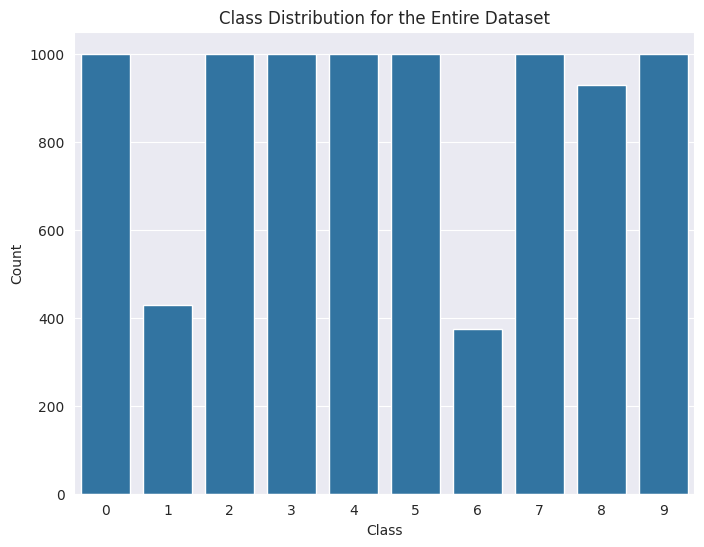

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['classID'])  
plt.title("Class Distribution for the Entire Dataset")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Classes of ID 1 and 6 show significant imbalance, when compared to other classes' counts. 

No over or under sampling techniques will be applied throghout this notebook, but imbalance was taken into consideration while evaluating each model's performance.

## Feature Extraction

When working with audio data, especially in the context of urban sound classification, it is highly beneficial to transform raw audio signals into **2D representations**. These representations capture both temporal and frequency information, leveraging the strengths of **Convolutional Neural Networks (CNNs)** in processing spatial data.

To achieve this, we use the `librosa` library to extract a variety of **audio features**, each capturing unique aspects of the sound. These features include:

- **Mel Spectrograms**: Representing the power spectrum of the audio signal on a Mel scale, capturing pitch and loudness over time.
- **MFCCs (Mel-Frequency Cepstral Coefficients)**: Extracting features that model the short-term power spectrum of the sound, commonly used in speech and audio recognition.
- **Chroma Features**: Representing the energy distribution across different pitch classes, useful for tonal and harmonic analysis.
- **Spectral Contrast**: Highlighting the difference between peaks and valleys in the spectrum, useful for differentiating sound textures.
- **Spectral Rolloff**: Measuring the frequency below which a specified percentage of the total spectral energy is concentrated, often used for timbre classification.
- **Zero-Crossing Rate**: Counting the number of times the signal crosses the zero amplitude line, commonly used for identifying percussive sounds.

By utilizing these features, we can create a **multi-stream CNN** architecture. This design processes different feature sets in parallel, enhancing the model's ability to learn **complex patterns** in the audio data. Each feature provides a unique perspective on the signal, and their combination allows the model to make more informed and accurate predictions.

In [6]:
def extract_features(audio_path, sample_rate=22050, duration=4):
    # Load and preprocess audio
    signal, sr = librosa.load(audio_path, sr=sample_rate, duration=duration)
    signal = librosa.util.fix_length(signal, size=sample_rate * duration)

    # Extract features
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    mfccs = librosa.feature.mfcc(S=mel_spec_db, n_mfcc=40)

    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)

    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sr)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=signal)

    return {
        'mel_spec': mel_spec_db,
        'mfccs': mfccs,
        'chroma': chroma,
        'spectral_contrast': spectral_contrast,
        'spectral_rolloff': spectral_rolloff,
        'zero_crossing_rate': zero_crossing_rate
    }

Before we proceed to extract features from all audio files, let's test our **extract_features** function on a sample audio file and visualize the features to ensure they are being extracted correctly.

In [7]:
# Select a sample audio file
sample_row = df.sample(n=1).iloc[0]
audio_path = f"UrbanSound8K/audio/fold{sample_row['fold']}/{sample_row['slice_file_name']}"

# Extract features
features = extract_features(audio_path)

# Display the audio path and class
print(f"Audio Path: {audio_path}")
print(f"Class ID: {sample_row['classID']}")


Audio Path: UrbanSound8K/audio/fold3/98681-9-0-7.wav
Class ID: 9


### Mel Spectogram

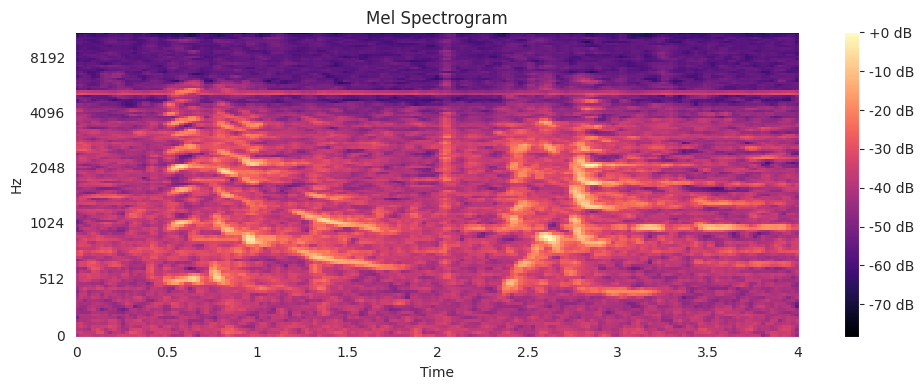

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features['mel_spec'], sr=22050, x_axis='time', y_axis='mel')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


### MFCCs (Mel-Frequency Cepstral Coefficients)

### Extracting Features From All Audio Files


This cell checks if features have been previously extracted and saved in a pickle file. If not, it processes all audio files in the dataset, extracts the relevant features, and saves them for future use.

In [9]:
# Check if features have been extracted previously
features_pickle = 'urbansound8k_features.pkl'

if os.path.isfile(features_pickle):
    # Load pre-extracted features
    with open(features_pickle, 'rb') as f:
        data = pickle.load(f)
    print('Features loaded from pickle file.')
else:
    # Extract features from all audio files
    print('Extracting features from audio files...')
    data = []
    audio_parent_dir = 'UrbanSound8K/audio/'
    for index, row in df.iterrows():
        file_name = row['slice_file_name']
        fold = row['fold']
        class_id = row['classID']
        file_path = os.path.join(audio_parent_dir, f'fold{fold}', file_name)

        if os.path.exists(file_path):
            features = extract_features(file_path)
            data.append({
                'mel_spec': features['mel_spec'],
                'mfccs': features['mfccs'],
                'chroma': features['chroma'],
                'spectral_contrast': features['spectral_contrast'],
                'spectral_rolloff': features['spectral_rolloff'],
                'zero_crossing_rate': features['zero_crossing_rate'],
                'label': class_id,
                'fold': fold
            })
        else:
            print(f'File not found: {file_path}')

    # Save extracted features
    with open(features_pickle, 'wb') as f:
        pickle.dump(data, f)
    print('Feature extraction completed and data saved.')


Features loaded from pickle file.


## Preparing Data For Model Input

This cell organizes the extracted features into separate arrays for each feature type (Mel Spectrogram, MFCCs, Chroma, Spectral Contrast, Rolloff, and Zero-Crossing Rate) and the corresponding labels. These arrays are now ready for input into the CNN model.

In [10]:
# Prepare data for model input
features_df = pd.DataFrame(data)

# Separate features and labels
X_mel = np.array(features_df['mel_spec'].tolist())
X_mfcc = np.array(features_df['mfccs'].tolist())
X_chroma = np.array(features_df['chroma'].tolist())
X_contrast = np.array(features_df['spectral_contrast'].tolist())
X_rolloff = np.array(features_df['spectral_rolloff'].tolist())
X_zcr = np.array(features_df['zero_crossing_rate'].tolist())
y = np.array(features_df['label'].tolist())


### Normalize Features

This cell normalizes the features using `StandardScaler` to ensure that each feature has a mean of 0 and a standard deviation of 1. This step ensures all features contribute equally to the learning process and improves model performance.

In [11]:
# Normalize features
scaler = StandardScaler()

def scale_features(X):
    num_samples, num_features, num_frames = X.shape
    X_flat = X.reshape(num_samples, -1)
    X_scaled = scaler.fit_transform(X_flat)
    X_scaled = X_scaled.reshape(num_samples, num_features, num_frames)
    return X_scaled

X_mel_scaled = scale_features(X_mel)
X_mfcc_scaled = scale_features(X_mfcc)
X_chroma_scaled = scale_features(X_chroma)
X_contrast_scaled = scale_features(X_contrast)
X_rolloff_scaled = scale_features(X_rolloff)
X_zcr_scaled = scale_features(X_zcr)


### Encode Labels

We will use one-hot encoding for the labels.



In [12]:
# Encode labels
num_classes = 10
y_encoded = to_categorical(y, num_classes=num_classes)

### Split Data into Training, Validation, and Test Sets

We initialize lists to store test accuracies and the cumulative confusion matrix. 

In [13]:
# Initialize lists to store results
test_accuracies = []
confusion_matrix_total = np.zeros((num_classes, num_classes), dtype=int)

This cell implements 10-fold cross-validation using `StratifiedKFold`. For each fold, the data is split into training, validation, and test sets. This process ensures that the model is trained and evaluated on different subsets of the data, providing a robust assessment of its performance.

In [14]:
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over each fold
for fold_num, (train_val_indices, test_indices) in enumerate(skf.split(X_mel_scaled, y), 1):
    print(f"\nProcessing Fold {fold_num}")

    # Further split train_val into training and validation sets
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=0.1, random_state=42, stratify=y[train_val_indices]
    )

    # Split the data
    X_mel_train = X_mel_scaled[train_indices]
    X_mfcc_train = X_mfcc_scaled[train_indices]
    X_chroma_train = X_chroma_scaled[train_indices]
    X_contrast_train = X_contrast_scaled[train_indices]
    X_rolloff_train = X_rolloff_scaled[train_indices]
    X_zcr_train = X_zcr_scaled[train_indices]
    y_train = y_encoded[train_indices]

    X_mel_val = X_mel_scaled[val_indices]
    X_mfcc_val = X_mfcc_scaled[val_indices]
    X_chroma_val = X_chroma_scaled[val_indices]
    X_contrast_val = X_contrast_scaled[val_indices]
    X_rolloff_val = X_rolloff_scaled[val_indices]
    X_zcr_val = X_zcr_scaled[val_indices]
    y_val = y_encoded[val_indices]

    X_mel_test = X_mel_scaled[test_indices]
    X_mfcc_test = X_mfcc_scaled[test_indices]
    X_chroma_test = X_chroma_scaled[test_indices]
    X_contrast_test = X_contrast_scaled[test_indices]
    X_rolloff_test = X_rolloff_scaled[test_indices]
    X_zcr_test = X_zcr_scaled[test_indices]
    y_test = y_encoded[test_indices]



Processing Fold 1

Processing Fold 2

Processing Fold 3

Processing Fold 4

Processing Fold 5

Processing Fold 6

Processing Fold 7

Processing Fold 8

Processing Fold 9

Processing Fold 10


This cell adjusts the feature shapes to match the expected input format for the model. 

- **1D Features** (Rolloff and ZCR): Transposed to `(samples, time_steps, 1)` for `Conv1D` compatibility.
- **2D Features** (Mel Spectrogram, MFCC, Chroma, and Spectral Contrast): A channel dimension is added to reshape them to `(samples, height, width, 1)` for `Conv2D` layers.

In [15]:
    # Transpose axes for rolloff and zcr
    X_rolloff_train = X_rolloff_train.transpose(0, 2, 1)
    X_zcr_train = X_zcr_train.transpose(0, 2, 1)

    X_rolloff_val = X_rolloff_val.transpose(0, 2, 1)
    X_zcr_val = X_zcr_val.transpose(0, 2, 1)

    X_rolloff_test = X_rolloff_test.transpose(0, 2, 1)
    X_zcr_test = X_zcr_test.transpose(0, 2, 1)

    # Add channel dimension to 2D features
    X_mel_train = X_mel_train[..., np.newaxis]
    X_mfcc_train = X_mfcc_train[..., np.newaxis]
    X_chroma_train = X_chroma_train[..., np.newaxis]
    X_contrast_train = X_contrast_train[..., np.newaxis]

    X_mel_val = X_mel_val[..., np.newaxis]
    X_mfcc_val = X_mfcc_val[..., np.newaxis]
    X_chroma_val = X_chroma_val[..., np.newaxis]
    X_contrast_val = X_contrast_val[..., np.newaxis]

    X_mel_test = X_mel_test[..., np.newaxis]
    X_mfcc_test = X_mfcc_test[..., np.newaxis]
    X_chroma_test = X_chroma_test[..., np.newaxis]
    X_contrast_test = X_contrast_test[..., np.newaxis]


## Model Creation

### Multi-Input CNN Model for Urban Sound Classification

This CNN model processes and combines multiple audio feature sets, leveraging their complementary information for robust urban sound classification. Each feature set has its own input stream, allowing the model to learn specialized patterns.

#### 1. **Input Streams**
- **Mel Spectrogram**: Captures both frequency and temporal information.
- **MFCCs (Mel-Frequency Cepstral Coefficients)**: Focuses on spectral and perceptual aspects of sound.
- **Chroma**: Represents tonal and harmonic patterns.
- **Spectral Contrast**: Highlights spectral variation and texture.
- **Spectral Rolloff**: Detects changes in the spectral distribution.
- **Zero-Crossing Rate (ZCR)**: Measures percussive and transient properties.

Each feature is fed into its own dedicated input stream, where convolutional layers process the feature-specific patterns.

#### 2. **Stream-Specific Layers**
- **Conv2D Layers (2D Features)**: Extract spatial patterns for Mel Spectrogram, MFCCs, Chroma, and Spectral Contrast.
- **Conv1D Layers (1D Features)**: Extract temporal patterns for Spectral Rolloff and ZCR.
- **MaxPooling**: Reduces dimensionality while retaining important features.
- **Flatten**: Converts processed feature maps into vectors for concatenation.

#### 3. **Combining Streams**
The processed outputs from all feature streams are combined using a `concatenate` layer, integrating complementary patterns learned from each feature type.

#### 4. **Fully Connected Layers**
- **Dense Layer (256 units)**: Captures complex interactions between combined features.
- **Dropout (50%)**: Reduces overfitting.
- **Dense Layer (128 units)**: Refines the feature representation.
- **Dropout (50%)**: Adds further regularization.

#### 5. **Output Layer**
The output layer uses a **softmax activation function** to classify the input into one of the predefined categories.

#### **Model Strengths**
- Specialized processing for each feature ensures optimal learning.
- Combining feature-specific streams integrates diverse information effectively.
- Dropout layers improve generalization.
- Flexible architecture for audio classification tasks.

This model is well-suited for tasks requiring the integration of multiple feature types, like urban sound classification.


### Define Input Shapes

To ensure compatibility with the model, we define **2D features** (Mel Spectrogram, MFCC, Chroma, and Spectral Contrast) with shapes like `(height, width, 1)` for Conv2D layers. These features require a **channel dimension** to leverage both temporal and frequency information.

For **1D features** (Spectral Rolloff and ZCR), we use shapes like `(time_steps, 1)` for Conv1D layers, focusing only on temporal patterns. This avoids errors and ensures each feature type is processed correctly.

---

In [16]:
    # Define input shapes
    mel_shape = X_mel_train.shape[1:]        # (128, time_steps, 1)
    mfcc_shape = X_mfcc_train.shape[1:]      # (40, time_steps, 1)
    chroma_shape = X_chroma_train.shape[1:]  # (12, time_steps, 1)
    contrast_shape = X_contrast_train.shape[1:]  # (7, time_steps, 1)
    rolloff_shape = (X_rolloff_train.shape[1], X_rolloff_train.shape[2])   # (time_steps, 1)
    zcr_shape = (X_zcr_train.shape[1], X_zcr_train.shape[2])              # (time_steps, 1)


## Build the Model


### Related Work and Inspirations for the Model

The use of **multi-input Convolutional Neural Networks (CNNs)** for audio classification is a well-established approach, with various studies demonstrating the power of combining multiple feature representations to improve classification accuracy. The design of our model draws inspiration from the following research:

1. **Multi-Representation Knowledge Distillation for Audio Classification**  
   This study introduces a multi-input CNN with branches that process different audio representations independently, combining their outputs for enhanced classification. In our project, we adopt a similar strategy by using separate input streams for each feature type (e.g., Mel Spectrogram, MFCCs, Chroma, etc.), allowing the model to learn specialized patterns from each representation. The idea of merging these streams into a combined representation is directly inspired by this work.  
   ([Source](https://link.springer.com/article/10.1007/s11042-021-11610-8))

2. **An Ensemble of Convolutional Neural Networks for Audio Classification**  
   This research explores ensembles of pre-trained CNNs, each fine-tuned on a specific audio feature. By aggregating the results of these CNNs, the study demonstrates improved performance across diverse datasets. Similarly, our model processes each feature type (e.g., Spectral Contrast and Zero-Crossing Rate) independently through dedicated CNN streams. Instead of using an ensemble of pre-trained networks, we combine the streams into a unified model, inspired by the concept of leveraging diverse feature-specific processing.  
   ([Source](https://www.mdpi.com/2076-3417/11/13/5796))

3. **Audio Classification Using Braided Convolutional Neural Networks**  
   This paper proposes a braided CNN architecture where different audio features are processed in parallel to capture both time and frequency components effectively. Our architecture mirrors this by employing parallel streams for 2D features (e.g., Mel Spectrogram and MFCCs) and 1D features (e.g., Rolloff and ZCR), ensuring that both temporal and frequency aspects are well represented. The use of Conv2D and Conv1D layers for different feature types in our model takes direct inspiration from this work.  
   ([Source](https://ietresearch.onlinelibrary.wiley.com/doi/pdfdirect/10.1049/iet-spr.2019.0381))

---

### Contribution of Our Model

Our multi-input CNN combines insights from these studies, focusing on:
- Specialized processing of diverse feature types using independent CNN streams.
- Integration of these streams into a combined representation for robust decision-making.
- Flexible use of both 2D and 1D convolutional layers to process spectral and temporal features effectively.

This approach ensures that the strengths of each feature type are fully utilized, leading to improved performance in urban sound classification tasks.

In [17]:
    # Mel Spectrogram Input Stream
    mel_input = Input(shape=mel_shape, name='mel_input')
    mel_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(mel_input)  
    mel_layer = MaxPooling2D((2, 2))(mel_layer)
    mel_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(mel_layer)  
    mel_layer = MaxPooling2D((2, 2))(mel_layer)
    mel_layer = Flatten()(mel_layer)
    
    # MFCCs Input Stream
    mfcc_input = Input(shape=mfcc_shape, name='mfcc_input')
    mfcc_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(mfcc_input) 
    mfcc_layer = MaxPooling2D((2, 2))(mfcc_layer)
    mfcc_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(mfcc_layer) 
    mfcc_layer = MaxPooling2D((2, 2))(mfcc_layer)
    mfcc_layer = Flatten()(mfcc_layer)
    
    # Chroma Input Stream
    chroma_input = Input(shape=chroma_shape, name='chroma_input')
    chroma_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(chroma_input)  
    chroma_layer = MaxPooling2D((2, 2))(chroma_layer)
    chroma_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(chroma_layer)  
    chroma_layer = MaxPooling2D((2, 2))(chroma_layer)
    chroma_layer = Flatten()(chroma_layer)
    
    # Spectral Contrast Input Stream
    contrast_input = Input(shape=contrast_shape, name='contrast_input')
    contrast_layer = Conv2D(32, (3, 3), activation='relu', padding='same')(contrast_input)  
    contrast_layer = MaxPooling2D((2, 2))(contrast_layer)
    contrast_layer = Conv2D(64, (3, 3), activation='relu', padding='same')(contrast_layer)  
    contrast_layer = MaxPooling2D((2, 2))(contrast_layer)
    contrast_layer = Flatten()(contrast_layer)


    # Spectral Rolloff Input Stream
    rolloff_input = Input(shape=rolloff_shape, name="rolloff_input")
    rolloff_layer = Conv1D(32, kernel_size=3, activation="relu")(rolloff_input)
    rolloff_layer = MaxPooling1D(pool_size=2)(rolloff_layer)
    rolloff_layer = Conv1D(64, kernel_size=3, activation="relu")(rolloff_layer)
    rolloff_layer = MaxPooling1D(pool_size=2)(rolloff_layer)
    rolloff_layer = Flatten()(rolloff_layer)

    # Zero-Crossing Rate Input Stream
    zcr_input = Input(shape=zcr_shape, name="zcr_input")
    zcr_layer = Conv1D(32, kernel_size=3, activation="relu")(zcr_input)
    zcr_layer = MaxPooling1D(pool_size=2)(zcr_layer)
    zcr_layer = Conv1D(64, kernel_size=3, activation="relu")(zcr_layer)
    zcr_layer = MaxPooling1D(pool_size=2)(zcr_layer)
    zcr_layer = Flatten()(zcr_layer)

    # Combine all streams
    combined = concatenate([
        mel_layer, mfcc_layer, chroma_layer, contrast_layer, rolloff_layer, zcr_layer
    ])

    # Fully connected layers
    dense_layer = Dense(256, activation='relu')(combined)
    dense_layer = Dropout(0.5)(dense_layer)
    dense_layer = Dense(128, activation='relu')(dense_layer)
    dense_layer = Dropout(0.5)(dense_layer)

    # Output layer
    output = Dense(num_classes, activation='softmax')(dense_layer)

    # Define the model
    model = Model(inputs=[mel_input, mfcc_input, chroma_input, contrast_input, rolloff_input, zcr_input], outputs=output)


### Complie the Model

In [18]:
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

### Define Callbakcs

We set up callbacks for early stopping and learning rate reduction

In [19]:
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


### Train the Model

In [ ]:
    # Train the model with tqdm progress bar
    history = model.fit(
        [X_mel_train, X_mfcc_train, X_chroma_train, X_contrast_train, X_rolloff_train, X_zcr_train],
        y_train,
        validation_data=(
            [X_mel_val, X_mfcc_val, X_chroma_val, X_contrast_val, X_rolloff_val, X_zcr_val],
            y_val
        ),
        epochs=50,
        batch_size=32,
        callbacks=[
            early_stopping,
            reduce_lr,
            TqdmCallback(verbose=1)
        ],
        verbose=0  # Set to 0 to prevent duplicate logs with tqdm
    )


0epoch [00:00, ?epoch/s]
  0%|          | 0/50 [00:00<?, ?epoch/s]
  0%|          | 0.00/222 [00:00<?, ?batch/s]
  0%|          | 1.00/222 [00:02<08:48, 2.39s/batch, accuracy=0.0625, loss=2.43]
  1%|          | 2.00/222 [00:02<04:21, 1.19s/batch, accuracy=0.0781, loss=13]  
  1%|▏         | 3.00/222 [00:03<02:56, 1.24batch/s, accuracy=0.0729, loss=14.3]
  2%|▏         | 4.00/222 [00:03<02:16, 1.59batch/s, accuracy=0.102, loss=13]   
  2%|▏         | 5.00/222 [00:03<01:55, 1.87batch/s, accuracy=0.119, loss=11.8]
  3%|▎         | 6.00/222 [00:04<01:42, 2.12batch/s, accuracy=0.125, loss=10.8]
  3%|▎         | 7.00/222 [00:04<01:33, 2.30batch/s, accuracy=0.134, loss=9.9] 
  4%|▎         | 8.00/222 [00:04<01:27, 2.44batch/s, accuracy=0.137, loss=9.07]
  4%|▍         | 9.00/222 [00:05<01:24, 2.53batch/s, accuracy=0.135, loss=8.41]
  5%|▍         | 10.0/222 [00:05<01:21, 2.60batch/s, accuracy=0.144, loss=7.8] 
  5%|▍         | 11.0/222 [00:06<01:22, 2.57batch/s, accuracy=0.145, loss=7.32]
  5

### Evaluate the Model

In [1]:
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(
        [X_mel_test, X_mfcc_test, X_chroma_test, X_contrast_test, X_rolloff_test, X_zcr_test],
        y_test,
        verbose=0
    )
    print(f'Fold {fold_num} Test Accuracy: {test_accuracy * 100:.2f}%')
    test_accuracies.append(test_accuracy)


NameError: name 'model' is not defined

## Update Confusion Matrix

In [ ]:
    # Predict labels
    y_pred = model.predict(
        [X_mel_test, X_mfcc_test, X_chroma_test, X_contrast_test, X_rolloff_test, X_zcr_test]
    )
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Update confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    confusion_matrix_total += cm


## Compute Average Accuracy

In [ ]:
# After all folds, compute average accuracy and standard deviation
avg_accuracy = np.mean(test_accuracies)
std_accuracy = np.std(test_accuracies)
print(f'\nAverage Test Accuracy: {avg_accuracy * 100:.2f}% (+/- {std_accuracy * 100:.2f}%)')


## Plot Cumulative Confusion Matrix

In [ ]:
# Plot cumulative confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_total, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Cumulative Confusion Matrix over 10 Folds')
plt.show()
